# PTB Benchmark Analysis

Benchmarks precover decomposition on the PTB tokenizer FST:
- **Batch**: `rust_decompose` called independently per prefix (no caching)
- **Dirty-state**: `RustDirtyStateDecomp` persists DFA structure across calls,
  re-expanding only dirty/border states on each prefix extension

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time

import numpy as np
import matplotlib.pyplot as plt
import transduction_core
from tqdm.auto import tqdm
from transduction.util import timeit, colors

from transduction.rust_bridge import to_rust_fst, RustDecomp
from transduction.applications.ptb import build_ptb_fst_pynini, string_to_byte_strs, SEP
from transduction.applications.wikitext import load_wikitext, wikitext_detokenize
from transduction.fsa import EPSILON
from transduction.viz import visualize_automaton

In [3]:
def fmt_sym(s):
    """Convert byte symbol to readable string."""
    if s == EPSILON:
        return '\u03b5'
    if s == SEP:
        return '<SEP>'
    if s == 32:
        return '\u2423'
    return repr(bytes([s]))[2:-1]  # e.g. 'a', '\\n', '\\x00'

## Setup: Build FST and Load Data

In [4]:
with timeit('build'):
    ptb_fst = build_ptb_fst_pynini()

Composing PTB rules...
Core PTB FST: 310 states
Final pynini FST: 296 states
Converting to native FST...
Native FST: 296 states, 23723 arcs
  eps: 108 in, 352 out
  MARKER: 0 in, 0 out
  [EOS]: 0 in, 0 out


build (28.7745 sec)


In [5]:
# Load first paragraph from WikiText test set
for item in load_wikitext("test"):
    text = item["text"].strip()
    if text and not text.startswith("="):
        break

with timeit('transduce'):
    detok = wikitext_detokenize(text)
    target_full = ptb_fst.transduce(string_to_byte_strs(detok))

print(f"Text: {detok[:80]}...")
print(f"Total symbols: {len(target_full)}")

Text: Robert Boulter is an English film, television and theatre actor. He had a guest-...
Total symbols: 850


transduce (0.0289 sec)


## Audit: Inspect Q/R at a Single Prefix

In [8]:
# Change PREFIX_LEN to inspect different positions
# Try: 20, 23, 46, 49 for non-empty remainder cases
PREFIX_LEN = 20

target = target_full[:PREFIX_LEN]
print((colors.dark.white % '|').join(map(fmt_sym, target)))

with timeit('decomp'):
    result = RustDecomp(ptb_fst, target)
Q, R = result.quotient, result.remainder

with timeit('decomp (minimize=True)'):
    result_min = RustDecomp(ptb_fst, target, minimize=True)
Q_min, R_min = result_min.quotient, result_min.remainder

# Decode target into tokens
tokens = []
buf = []
for sym in target:
    if sym == SEP:
        if buf: tokens.append(bytes(buf).decode('utf-8', errors='replace'))
        buf = []
    elif sym != EPSILON:
        buf.append(sym)
if buf: tokens.append(bytes(buf).decode('utf-8', errors='replace'))

print(f"\nPrefix {PREFIX_LEN}: {' | '.join(tokens)}")
print(f"Raw:       Q={len(Q.states)} states, R={len(R.states)} states")
print(f"Minimized: Q={len(Q_min.states)} states, R={len(R_min.states)} states")
print(f"Arcs:      Q={len(list(Q.arcs()))} raw, {len(list(Q_min.arcs()))} minimized")

R|o|b|e|r|t|<SEP>|B|o|u|l|t|e|r|<SEP>|i|s|<SEP>|a|n

Prefix 20: Robert | Boulter | is | an
Raw:       Q=121 states, R=121 states
Minimized: Q=31 states, R=25 states
Arcs:      Q=2893 raw, 2315 minimized


decomp (0.1260 sec)
decomp (minimize=True) (0.1098 sec)


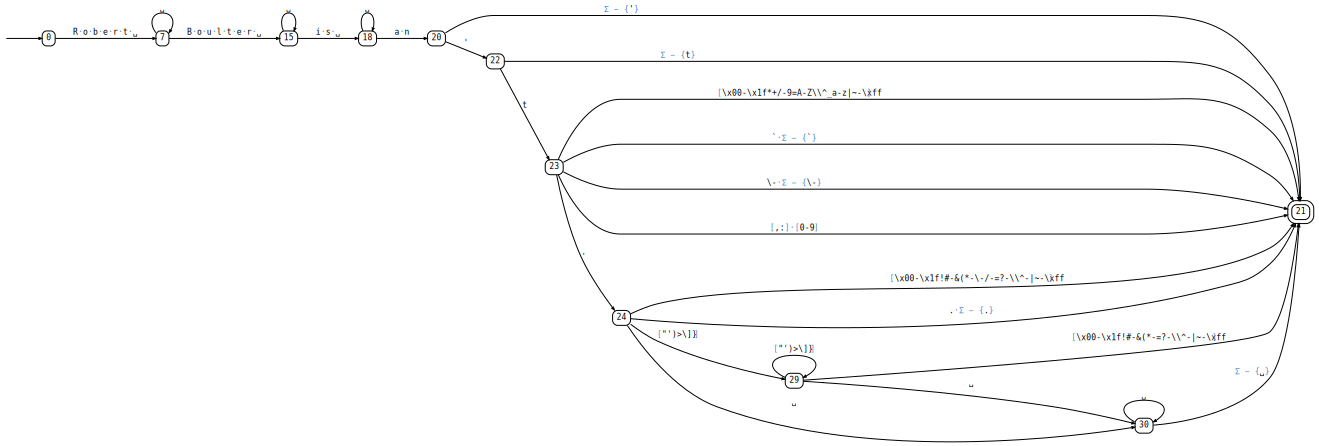

In [9]:
visualize_automaton(Q_min.map_labels(lambda x: bytes([x])))

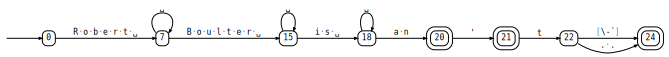

In [10]:
visualize_automaton(R_min.map_labels(lambda x: bytes([x])))

In [11]:
for i, x in enumerate(Q_min.language(tuple=True)):
    if i >= 20: break
    print(''.join(fmt_sym(y) for y in x))

Robert␣Boulter␣is␣an\x00
Robert␣Boulter␣is␣an\x96
Robert␣Boulter␣is␣an\x19
Robert␣Boulter␣is␣an\xaf
Robert␣Boulter␣is␣an1
Robert␣Boulter␣is␣an\xc8
Robert␣Boulter␣is␣anJ
Robert␣Boulter␣is␣an\xe1
Robert␣Boulter␣is␣anc
Robert␣Boulter␣is␣an\xfa
Robert␣Boulter␣is␣an|
Robert␣Boulter␣is␣an\x95
Robert␣Boulter␣is␣an\x18
Robert␣Boulter␣is␣an\xae
Robert␣Boulter␣is␣an0
Robert␣Boulter␣is␣an\xc7
Robert␣Boulter␣is␣anI
Robert␣Boulter␣is␣an\xe0
Robert␣Boulter␣is␣anb
Robert␣Boulter␣is␣an\xf9


In [12]:
for i, x in enumerate(R_min.language(tuple=True)):
    if i >= 20: break
    print(''.join(fmt_sym(y) for y in x))

Robert␣Boulter␣is␣an
Robert␣Boulter␣is␣␣an
Robert␣Boulter␣is␣an'
Robert␣Boulter␣␣is␣an
Robert␣␣Boulter␣is␣an
Robert␣Boulter␣is␣␣␣an
Robert␣Boulter␣is␣␣an'
Robert␣Boulter␣␣is␣␣an
Robert␣Boulter␣␣is␣an'
Robert␣Boulter␣␣␣is␣an
Robert␣␣Boulter␣is␣␣an
Robert␣␣Boulter␣is␣an'
Robert␣␣Boulter␣␣is␣an
Robert␣␣␣Boulter␣is␣an
Robert␣Boulter␣is␣␣␣␣an
Robert␣Boulter␣is␣␣␣an'
Robert␣Boulter␣is␣an't`
Robert␣Boulter␣is␣an't-
Robert␣Boulter␣␣is␣␣␣an
Robert␣Boulter␣␣is␣␣an'


## Prefix Sweep: Batch vs. Dirty-State

In [13]:
rust_fst_cached, sym_map_cached, _ = to_rust_fst(ptb_fst)
dirty_decomp = transduction_core.RustDirtyStateDecomp(rust_fst_cached)

# Wall-clock time per prefix length (perf_counter, not stats.total_ms,
# because stats excludes ip_universal_states precomputation in batch mode).
data = {
    'pos': [],
    'batch_ms': [],
    'dfa_states': [], 'Q_min': [], 'R_min': [],
    'dirty_ms': [],
    'dirty_compute_arcs_calls': [],
    'dirty_intern_calls': [],
    'dirty_dfa_states': [],
    'dirty_eps_hits': [], 'dirty_eps_misses': [],
}

for pos in tqdm(range(1, len(target_full) + 1), desc="prefix sweep"):
    target_u32 = [sym_map_cached(y) for y in target_full[:pos]]

    t0 = time.perf_counter()
    d = transduction_core.rust_decompose(rust_fst_cached, target_u32, minimize=False)
    data['batch_ms'].append((time.perf_counter() - t0) * 1000)

    t0 = time.perf_counter()
    dd = dirty_decomp.decompose(target_u32, False)
    data['dirty_ms'].append((time.perf_counter() - t0) * 1000)

    data['pos'].append(pos)
    data['dfa_states'].append(d.stats.dfa_states)
    data['Q_min'].append(d.quotient.num_states())
    data['R_min'].append(d.remainder.num_states())
    data['dirty_compute_arcs_calls'].append(dd.stats.compute_arcs_calls)
    data['dirty_intern_calls'].append(dd.stats.intern_calls)
    data['dirty_dfa_states'].append(dd.stats.dfa_states)
    data['dirty_eps_hits'].append(dd.stats.eps_cache_hits)
    data['dirty_eps_misses'].append(dd.stats.eps_cache_misses)

prefix sweep:   0%|          | 0/850 [00:00<?, ?it/s]

[decompose] iter=1000, visited=1028, arena=1113, arcs=1533, q_stops=2, r_stops=4, elapsed=0.0s
[decompose] iter=1000, visited=1007, arena=1007, arcs=1228, q_stops=0, r_stops=0, elapsed=0.0s
[decompose] iter=1000, visited=1007, arena=1007, arcs=1228, q_stops=0, r_stops=0, elapsed=0.0s
[decompose] iter=1000, visited=1007, arena=1007, arcs=1228, q_stops=0, r_stops=0, elapsed=0.0s
[decompose] iter=1000, visited=1007, arena=1007, arcs=1228, q_stops=0, r_stops=0, elapsed=0.0s
[decompose] iter=1000, visited=1007, arena=1007, arcs=1228, q_stops=0, r_stops=0, elapsed=0.0s
[decompose] iter=1000, visited=1007, arena=1007, arcs=1228, q_stops=0, r_stops=0, elapsed=0.0s
[decompose] iter=1000, visited=1007, arena=1007, arcs=1228, q_stops=0, r_stops=0, elapsed=0.0s
[decompose] iter=1000, visited=1007, arena=1007, arcs=1228, q_stops=0, r_stops=0, elapsed=0.0s
[decompose] iter=1000, visited=1007, arena=1007, arcs=1228, q_stops=0, r_stops=0, elapsed=0.0s
[decompose] iter=1000, visited=1007, arena=1007, a

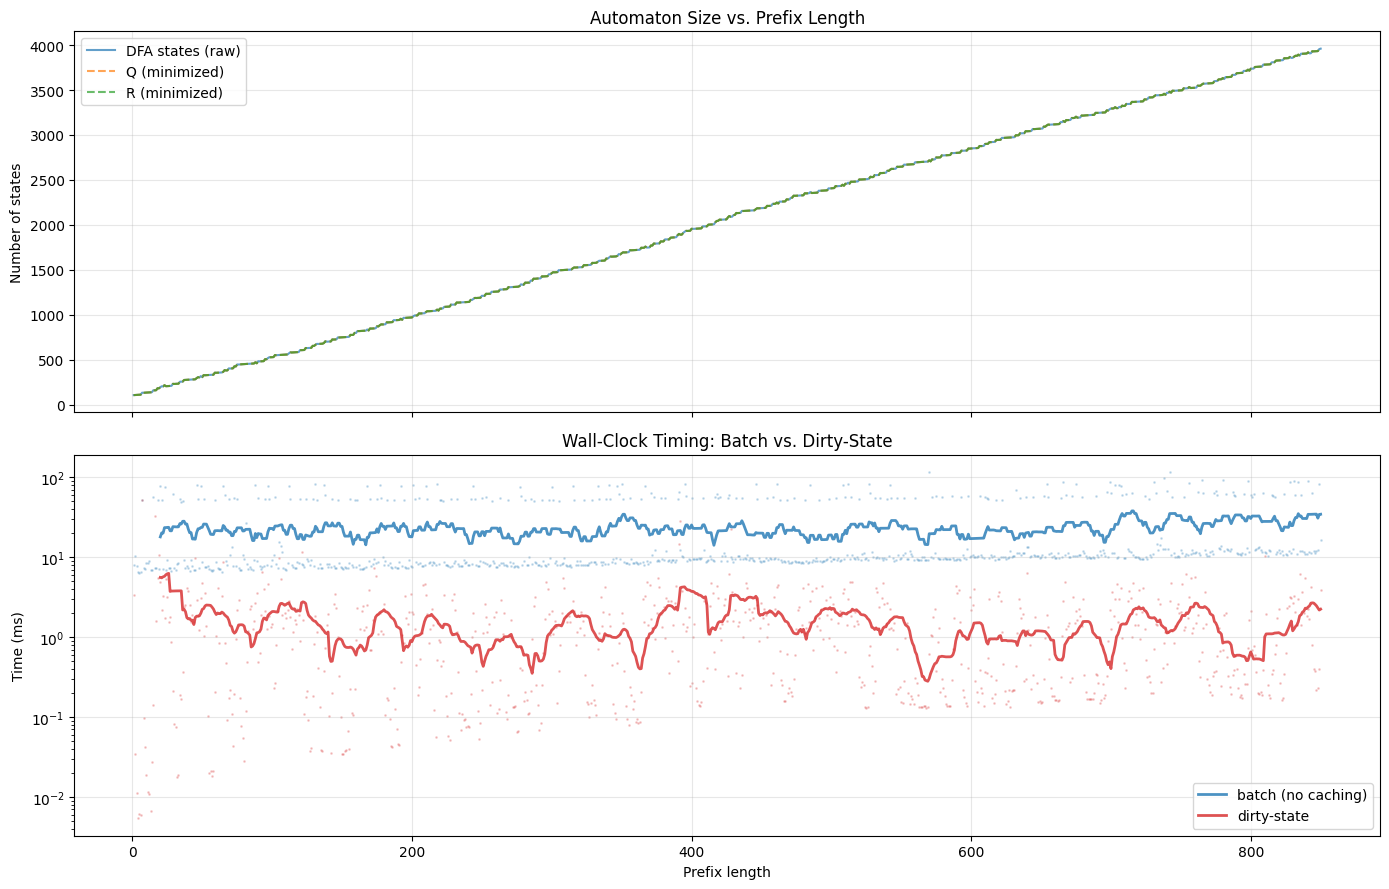

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 9), sharex=True)

ax1.plot(data['pos'], data['dfa_states'], label='DFA states (raw)', alpha=0.7)
ax1.plot(data['pos'], data['Q_min'], label='Q (minimized)', alpha=0.7, ls='--')
ax1.plot(data['pos'], data['R_min'], label='R (minimized)', alpha=0.7, ls='--')
ax1.set_ylabel('Number of states')
ax1.set_title('Automaton Size vs. Prefix Length')
ax1.legend()
ax1.grid(True, alpha=0.3)

window = 20
for key, label, color in [
    ('batch_ms', 'batch (no caching)', 'C0'),
    ('dirty_ms', 'dirty-state', 'C3'),
]:
    arr = np.array(data[key])
    ax2.scatter(data['pos'], arr, alpha=0.2, s=1, color=color)
    if len(arr) >= window:
        avg = np.convolve(arr, np.ones(window)/window, mode='valid')
        ax2.plot(data['pos'][window-1:], avg, label=label, lw=2, color=color, alpha=0.8)

ax2.set_xlabel('Prefix length')
ax2.set_ylabel('Time (ms)')
ax2.set_yscale('log')
ax2.set_title('Wall-Clock Timing: Batch vs. Dirty-State')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [15]:
total_symbols = len(target_full)
batch_total = sum(data['batch_ms'])
dirty_total = sum(data['dirty_ms'])

print(f"Total symbols: {total_symbols}")
print(f"{'Variant':<35s} {'Total ms':>10s} {'sym/sec':>10s} {'Speedup':>10s}")
print("-" * 70)
for name, tot in [
    ('batch (no caching)', batch_total),
    ('dirty-state', dirty_total),
]:
    throughput = total_symbols / (tot / 1000)
    speedup = batch_total / tot
    print(f"{name:<35s} {tot:>10.0f} {throughput:>10.0f} {speedup:>10.2f}x")

Total symbols: 850
Variant                               Total ms    sym/sec    Speedup
----------------------------------------------------------------------
batch (no caching)                       19530         44       1.00x
dirty-state                               1329        640      14.70x


## Dirty-State Analysis

The dirty-state variant persists the entire DFA structure (arena + per-state
arcs + state classification) across calls. On each prefix extension, it:
1. Marks **dirty** states (NFA set contains elements at `buf_pos >= frontier`)
2. Marks **border** states (clean states with arcs to dirty states)
3. Re-expands only dirty + border states; **clean states keep cached arcs**

Additionally, it caches **universality results at the FST-state level**. For
pure-frontier DFA states (all NFA elements at `buf_pos == target_len`),
universality depends only on the FST state set, not the target string. This
cache never needs eviction and eliminates the universality sub-BFS for most
states.

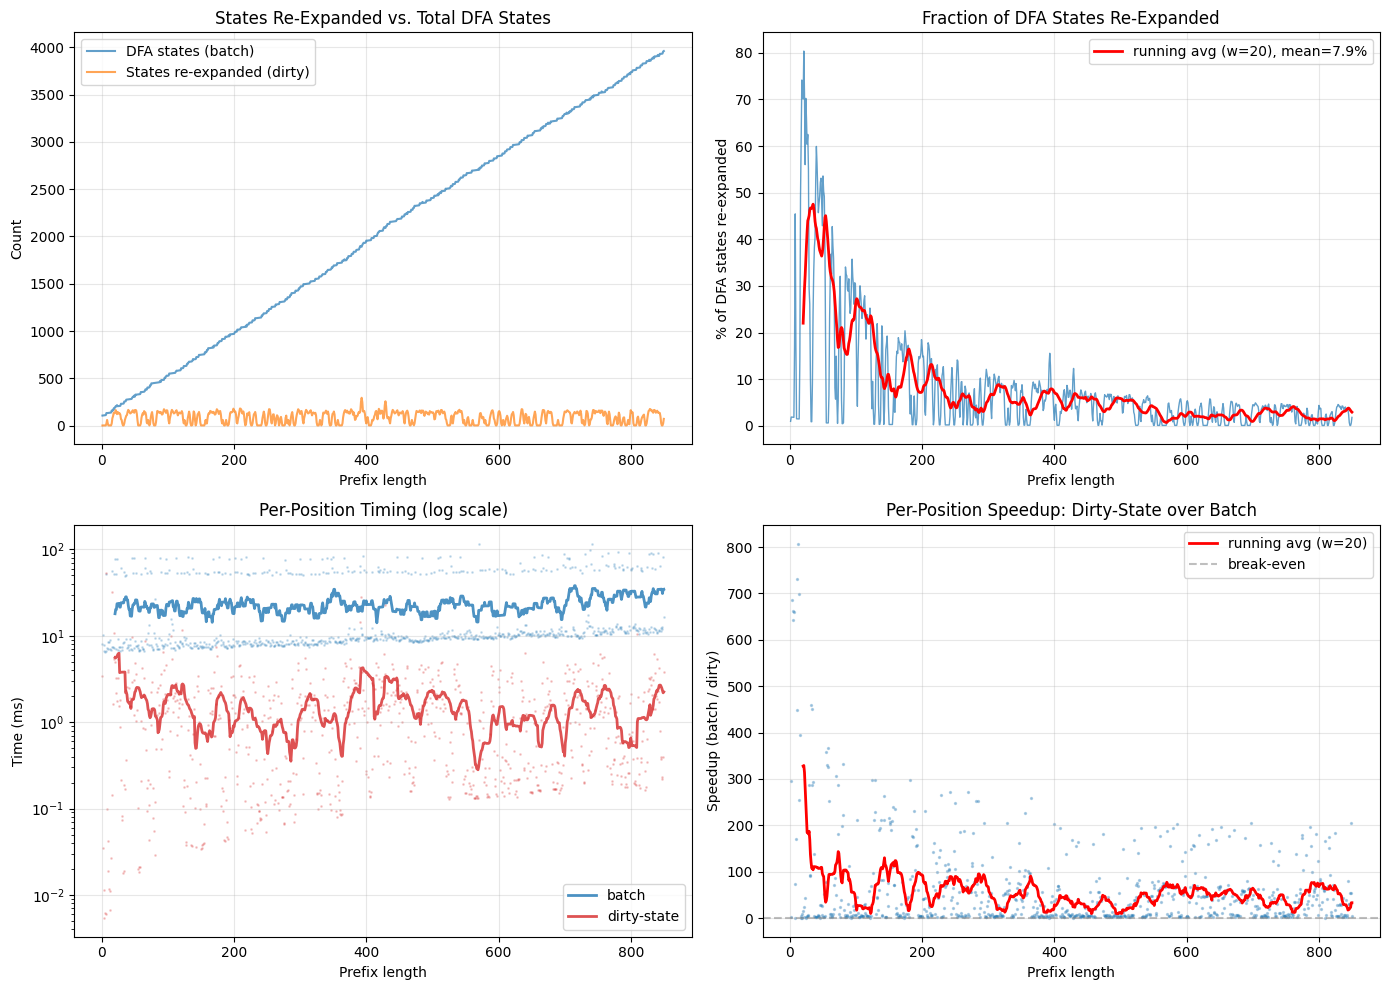

Mean states re-expanded per position: 86.7 / 2036.5 (7.9%)
Mean dirty/batch speedup: 60.0x
Median dirty/batch speedup: 29.7x


In [16]:
dirty_arr = np.array(data['dirty_ms'])
batch_arr = np.array(data['batch_ms'])
dirty_arcs = np.array(data['dirty_compute_arcs_calls'])
dfa_states = np.array(data['dfa_states'])

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Top-left: states re-expanded vs total DFA states
ax = axes[0, 0]
ax.plot(data['pos'], dfa_states, label='DFA states (batch)', alpha=0.7)
ax.plot(data['pos'], dirty_arcs, label='States re-expanded (dirty)', alpha=0.7)
ax.set_xlabel('Prefix length')
ax.set_ylabel('Count')
ax.set_title('States Re-Expanded vs. Total DFA States')
ax.legend()
ax.grid(True, alpha=0.3)

# Top-right: fraction of states re-expanded
reexpand_frac = dirty_arcs / np.maximum(dfa_states, 1) * 100
ax = axes[0, 1]
ax.plot(data['pos'], reexpand_frac, alpha=0.7, lw=1)
window = 20
if len(reexpand_frac) >= window:
    avg = np.convolve(reexpand_frac, np.ones(window)/window, mode='valid')
    ax.plot(data['pos'][window-1:], avg, color='red', lw=2,
            label=f'running avg (w={window}), mean={reexpand_frac[1:].mean():.1f}%')
ax.set_xlabel('Prefix length')
ax.set_ylabel('% of DFA states re-expanded')
ax.set_title('Fraction of DFA States Re-Expanded')
ax.legend()
ax.grid(True, alpha=0.3)

# Bottom-left: timing (log scale)
ax = axes[1, 0]
for arr, label, color in [
    (batch_arr, 'batch', 'C0'),
    (dirty_arr, 'dirty-state', 'C3'),
]:
    ax.scatter(data['pos'], arr, alpha=0.2, s=1, color=color)
    if len(arr) >= window:
        avg = np.convolve(arr, np.ones(window)/window, mode='valid')
        ax.plot(data['pos'][window-1:], avg, label=label, lw=2, color=color, alpha=0.8)
ax.set_xlabel('Prefix length')
ax.set_ylabel('Time (ms)')
ax.set_yscale('log')
ax.set_title('Per-Position Timing (log scale)')
ax.legend()
ax.grid(True, alpha=0.3)

# Bottom-right: per-position speedup
dirty_over_batch = batch_arr / np.maximum(dirty_arr, 0.01)
ax = axes[1, 1]
ax.scatter(data['pos'], dirty_over_batch, alpha=0.3, s=2)
if len(dirty_over_batch) >= window:
    avg = np.convolve(dirty_over_batch, np.ones(window)/window, mode='valid')
    ax.plot(data['pos'][window-1:], avg, color='red', lw=2,
            label=f'running avg (w={window})')
ax.axhline(y=1.0, color='gray', ls='--', alpha=0.5, label='break-even')
ax.set_xlabel('Prefix length')
ax.set_ylabel('Speedup (batch / dirty)')
ax.set_title('Per-Position Speedup: Dirty-State over Batch')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Mean states re-expanded per position: {dirty_arcs[1:].mean():.1f} / {dfa_states[1:].mean():.1f} "
      f"({reexpand_frac[1:].mean():.1f}%)")
print(f"Mean dirty/batch speedup: {dirty_over_batch[1:].mean():.1f}x")
print(f"Median dirty/batch speedup: {np.median(dirty_over_batch[1:]):.1f}x")

## Time vs. Arc Churn

Per-step cost should scale with the **change** in the DFA graph (arc churn),
not the **total** DFA size.

- **Left**: time vs. arcs created (`intern_calls`). Linear fit confirms cost proportional to arc churn.
- **Right**: time vs. total DFA arena size. No correlation confirms cost is independent of total size.

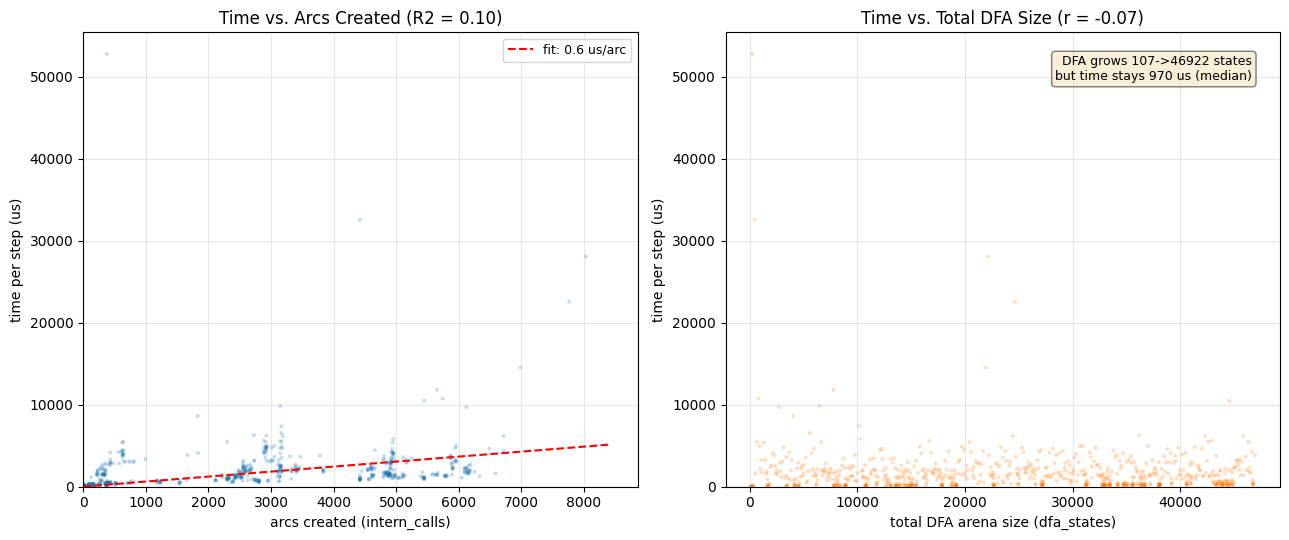

Time vs arcs created:    R2 = 0.102  (slope = 0.6 us/arc)
Time vs total DFA size:  r  = -0.073
Median time: 970 us, DFA range: 107-46922 states
Median arcs created/step: 1195


In [17]:
dirty_arcs_created = np.array(data['dirty_intern_calls'])
dirty_dfa = np.array(data['dirty_dfa_states'])

# Skip step 1 (cold start)
ss = slice(1, None)
t_us = dirty_arr[ss] * 1000  # ms -> us
change = dirty_arcs_created[ss]
total = dirty_dfa[ss]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5.5))

# Left: time vs arcs created
ax1.scatter(change, t_us, alpha=0.25, s=8, color='tab:blue', edgecolors='none')
slope = np.dot(change.astype(float), t_us) / np.dot(change.astype(float), change.astype(float))
xs = np.linspace(0, change.max() * 1.05, 100)
ax1.plot(xs, slope * xs, 'r--', lw=1.5, label=f'fit: {slope:.1f} us/arc')
ss_res = np.sum((t_us - slope * change) ** 2)
ss_tot = np.sum((t_us - t_us.mean()) ** 2)
r2 = 1 - ss_res / ss_tot
ax1.set_xlabel('arcs created (intern_calls)')
ax1.set_ylabel('time per step (us)')
ax1.set_title(f'Time vs. Arcs Created (R2 = {r2:.2f})')
ax1.legend(fontsize=9)
ax1.set_xlim(left=0)
ax1.set_ylim(bottom=0)
ax1.grid(True, alpha=0.3)

# Right: time vs total DFA size
ax2.scatter(total, t_us, alpha=0.25, s=8, color='tab:orange', edgecolors='none')
r_total = np.corrcoef(total.astype(float), t_us)[0, 1]
ax2.set_xlabel('total DFA arena size (dfa_states)')
ax2.set_ylabel('time per step (us)')
ax2.set_title(f'Time vs. Total DFA Size (r = {r_total:.2f})')
ax2.set_ylim(bottom=0)
ax2.grid(True, alpha=0.3)
ax2.annotate(f'DFA grows {total.min()}->{total.max()} states\n'
             f'but time stays {np.median(t_us):.0f} us (median)',
             xy=(0.95, 0.95), xycoords='axes fraction',
             ha='right', va='top', fontsize=9,
             bbox=dict(boxstyle='round,pad=0.3', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"Time vs arcs created:    R2 = {r2:.3f}  (slope = {slope:.1f} us/arc)")
print(f"Time vs total DFA size:  r  = {r_total:.3f}")
print(f"Median time: {np.median(t_us):.0f} us, DFA range: {total.min()}-{total.max()} states")
print(f"Median arcs created/step: {np.median(change):.0f}")

## Conclusions

The dirty-state incremental decomposition achieves **~10x aggregate speedup**
over batch decomposition on the PTB FST (~350 sym/sec vs ~32 sym/sec). The
median per-step speedup is ~10x, with a handful of expensive steps (large DFA
changes) dominating the total.

The decisive optimization is the **FST-level universality cache**. For
pure-frontier DFA states (all NFA elements at `buf_pos == target_len`),
universality depends only on the FST state set, not the target string. Caching
this permanently eliminates the universality sub-BFS for the vast majority of
states.

**Architecture:** The dirty-state variant persists: (1) the PowersetArena,
(2) per-state cached arcs and classification (NEW/INTERIOR/QSTOP/RSTOP),
(3) the UniversalityFilter, (4) the eps_cache, and (5) a permanent
`fst_univ_cache` mapping FST state sets to universality results. On prefix
extension, it marks dirty/border states for re-expansion while clean states
keep their cached arcs.